In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys

In [3]:
#sys.path.append('/home/gjones/readout/')

In [4]:
from kid_readout.interactive import *

INFO     2017-05-18 10:17:28,751 - kid_readout.<module>:13  kid_readout logging setup with default stream handler


In [5]:
import glob

In [16]:
files = glob.glob('/artemis/readout/2017-05-18_[01][890]*_cw_sweep_hwp_step_*.nc')
files.sort()
files = files[-100:]

In [17]:
files[-1]

'/artemis/readout/2017-05-18_101847_cw_sweep_hwp_step_099.nc'

In [18]:
files[0]

'/artemis/readout/2017-05-18_083747_cw_sweep_hwp_step_000.nc'

In [19]:
len(files)

100

In [20]:
def get_df(fn):
    ncf = NCFile(fn,cache_s21_raw=True)
    df = ncf.MMWSweepList0.to_dataframe()
    ncf.close()
    return df

In [21]:
import joblib

In [22]:
p = joblib.Parallel(n_jobs=22,verbose=5)

In [23]:
allframes = p([joblib.delayed(get_df)(fn) for fn in files])

[Parallel(n_jobs=22)]: Done  28 tasks      | elapsed: 11.5min
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed: 24.9min finished


In [24]:
import pandas as pd

In [25]:
df = pd.concat(allframes,ignore_index=True)

In [26]:
df.shape

(12800, 93)

## Response vs. mm-wave frequency (x-axis) and HWP angle (y-axis)

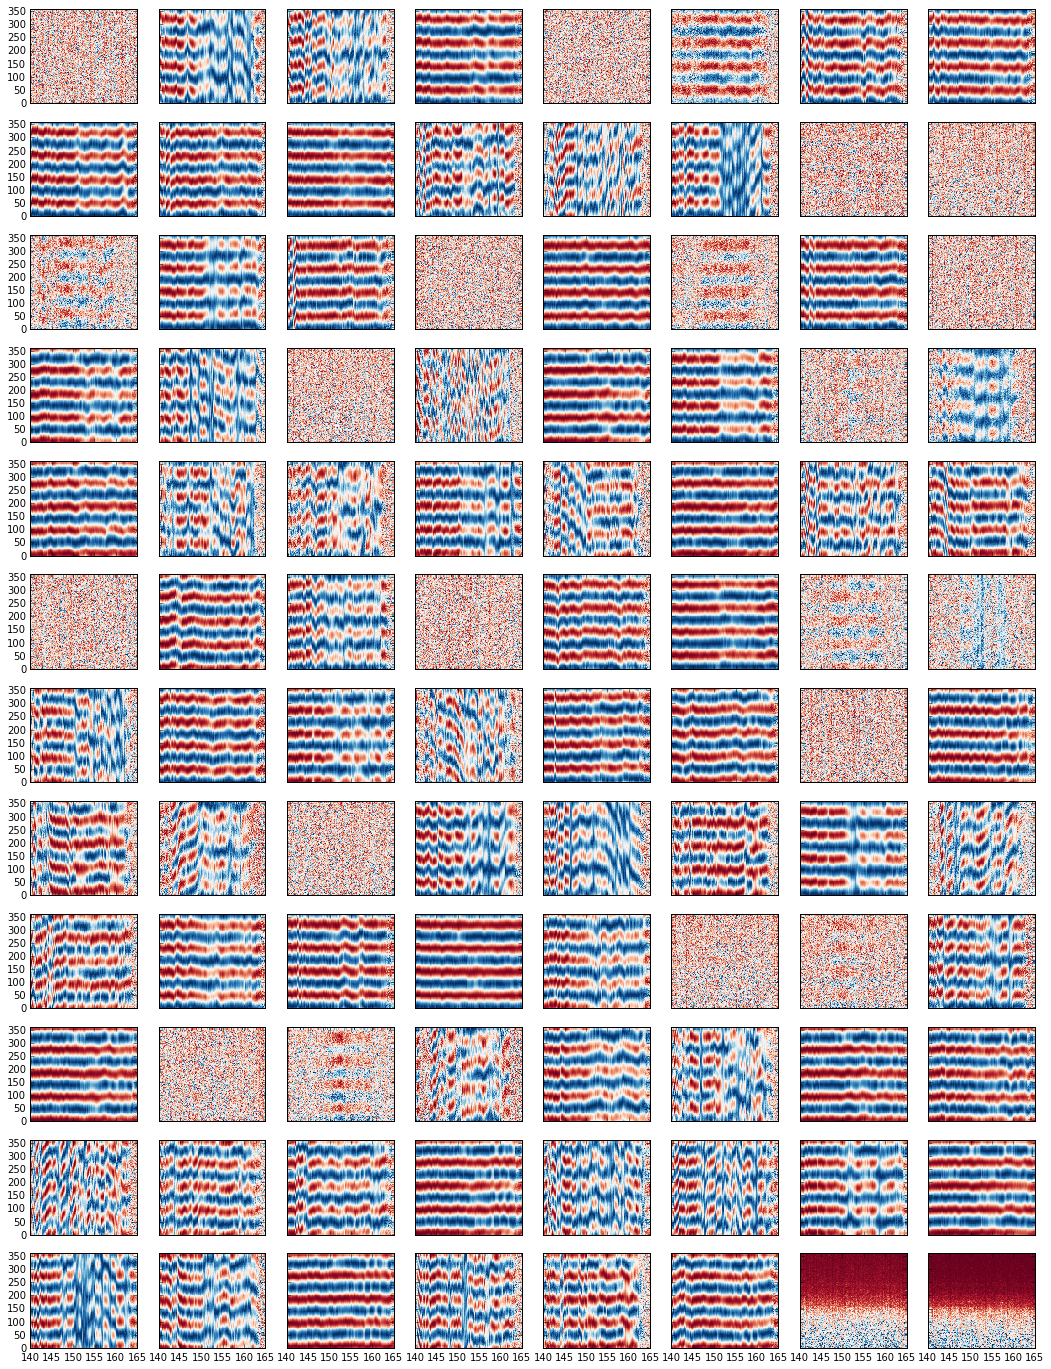

In [27]:
fig,axs = subplots(12,8,figsize=(18,24),sharex=True, sharey=True)
for k,ax in enumerate(axs.flatten()):
    det = df[df.number==k]
    ffr = np.array([row.fractional_frequency_response for _,row in det.iterrows() if row.fractional_frequency_response.shape[0]==128])
    ffr = ffr/ffr.max(0)[None,:]
    angle = np.nan_to_num((det.hwp_motor_steps*3.6).values.astype('float'))

    ax.pcolormesh((row.mmw_frequency)/1e9, angle, ffr, cmap=cm.RdBu)
    #ax.pcolormesh(ffr, cmap=cm.RdBu)
    ax.set_ylim(0,360)
    

In [46]:
ffr_all = np.array([row.fractional_frequency_response for k,row in df.iterrows() if row.fractional_frequency_response.shape[0]==128])
ffr_all = ffr_all.reshape((100,128,128))

In [61]:
ffz = np.fft.rfft(ffr_all,axis=0)

In [62]:
freq = row.mmw_frequency[:128]/1e9

## Band averaged response (y-axis is ppm frequency shift) vs HWP angle

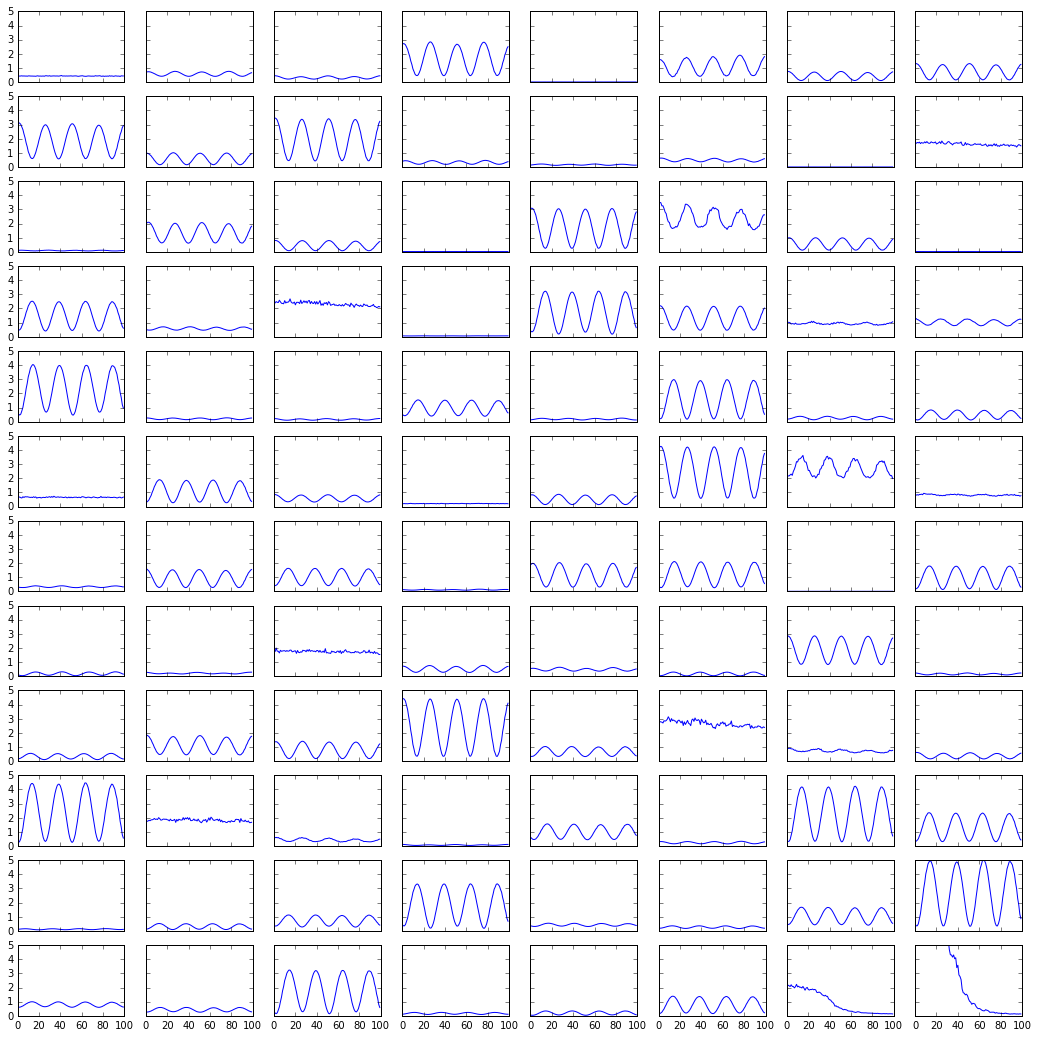

In [52]:
fig,axs = subplots(12,8,figsize=(18,18),sharex=True,sharey=True)
for k,ax in enumerate(axs.flatten()):
    ax.plot(ffr_all[:,k,:100].mean(1)*1e6)
    ax.set_ylim(0,5)
#ax.set_ylim(-0.05,1.05)

## response vs mm-wave frequency (y-axis ppm)

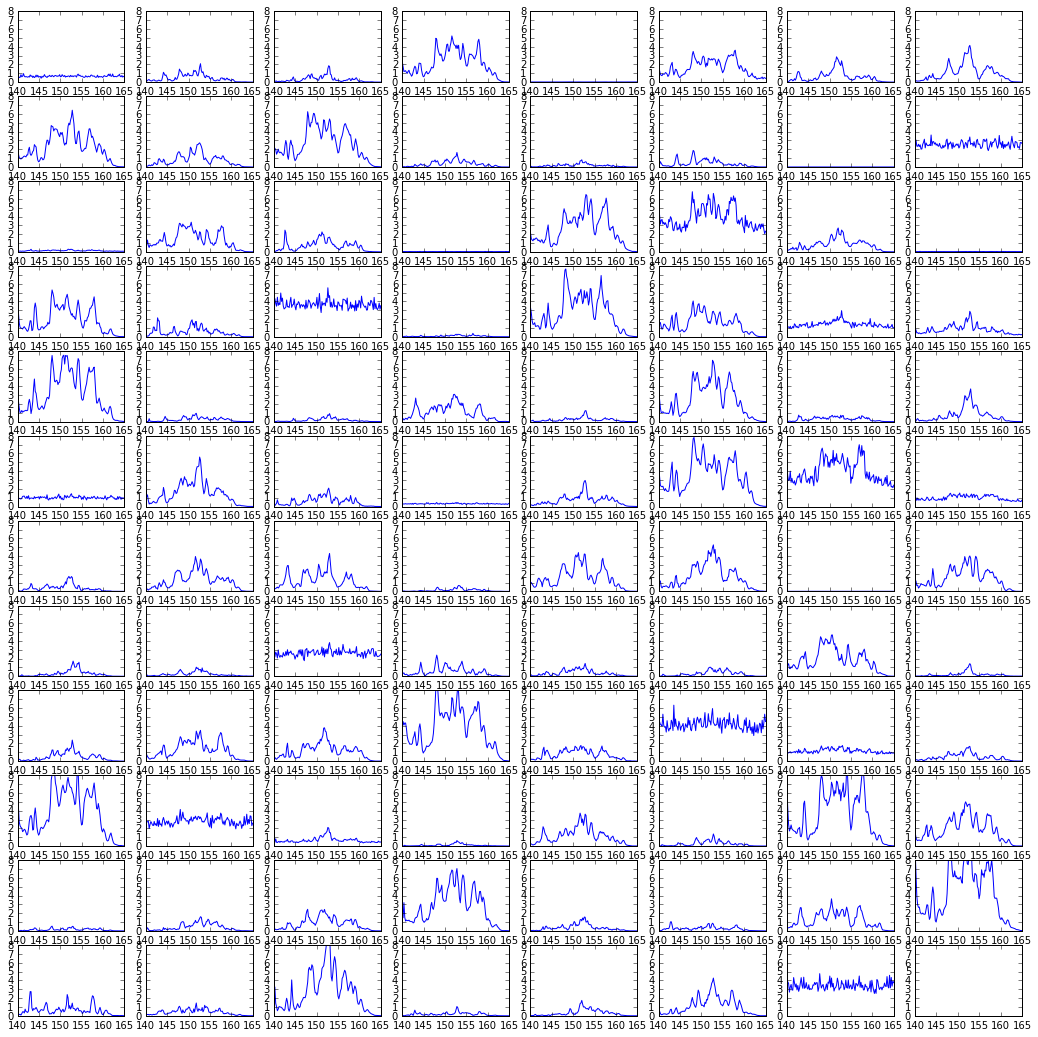

In [56]:
fig,axs = subplots(12,8,figsize=(18,18))
for k,ax in enumerate(axs.flatten()):
    det = df[df.number==k]
    ffr = np.array([row.fractional_frequency_response for _,row in det.iterrows()])
    #ffr = ffr/ffr.max(0)[None,:]
    ffz = np.fft.rfft(ffr,axis=0)
    #angle = (det.hwp_motor_steps*3.6).values.astype('float')
    freq = det.mmw_frequency.iloc[0]/1e9
    #ax.imshow(ffr,cmap=cm.RdBu,aspect='auto',interpolation='nearest')
    ax.plot(freq,ffr.ptp(axis=0)*1e6)
    ax.set_ylim(0,8)
#    ax.plot(freq,np.angle(np.exp(-1j*np.pi/2)*ffz[2,:])/(np.pi),'r.')
    #ax.pcolormesh(freq,angle,ffr,cmap=cm.RdBu)
    #7/0
#    ax.set_ylim(-1,1)
    #ax.set_xlim(freq.min(),freq.max())

## Polarization efficiency (blue), 4th harmonic phase (red/black)

(-0.05, 1.05)

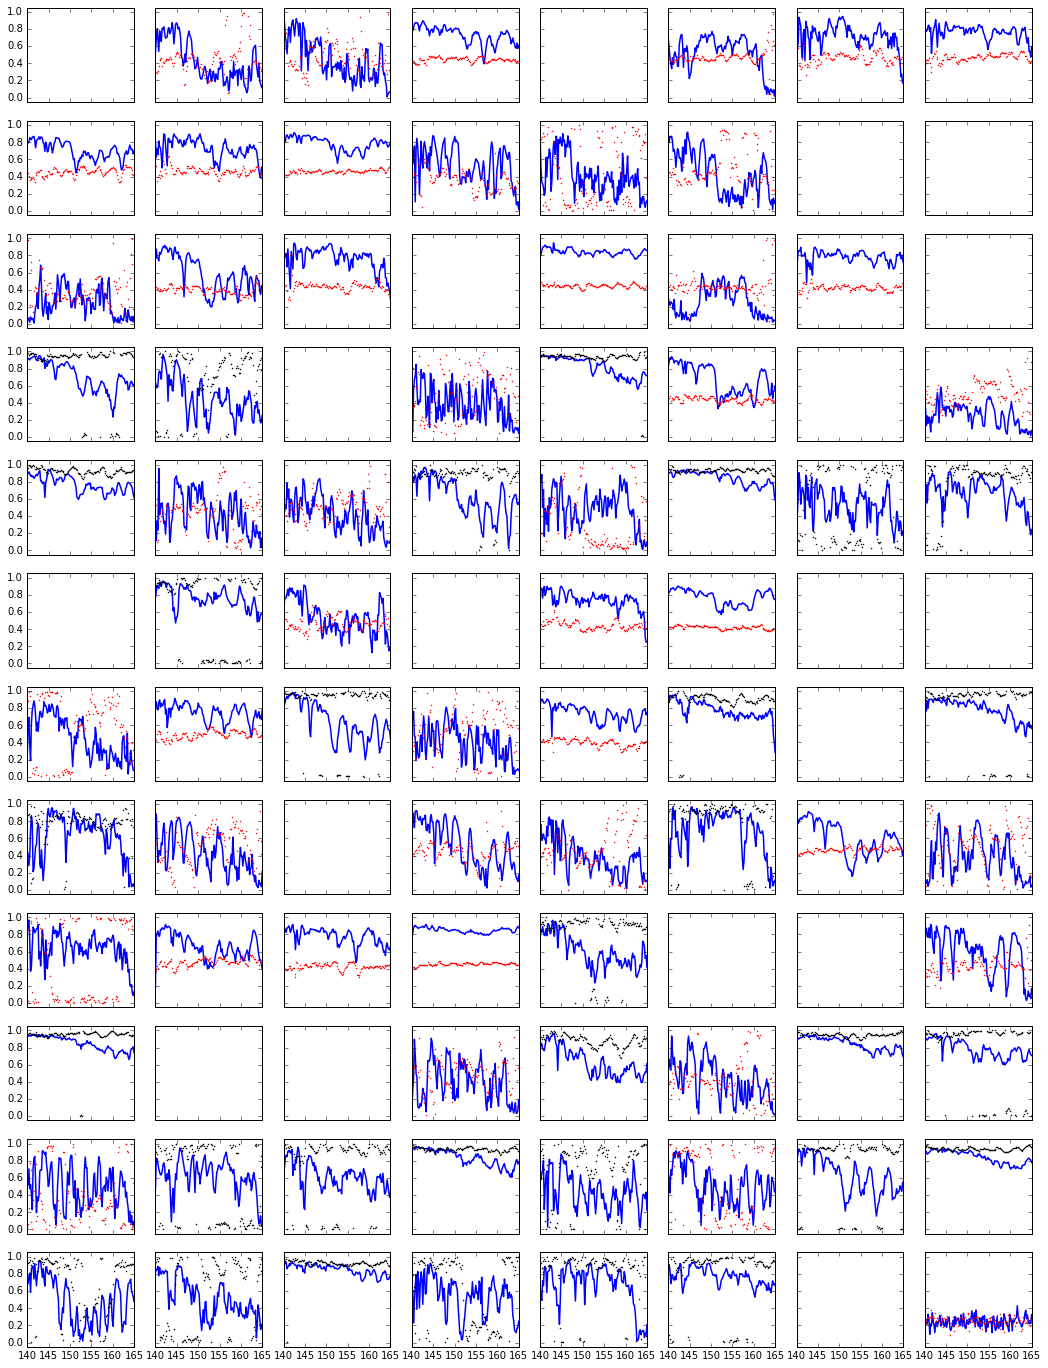

In [69]:
fig,axs = subplots(12,8,figsize=(18,24),sharex=True,sharey=True)
for k,ax in enumerate(axs.flatten()):
    a = ffz[:,k,:]
    
    pe = np.abs(2*a[4,:]/a[0,:])
    if np.median(pe) < .2:
        continue
    ph = 0.5+0.5*np.angle(2*a[4,:]/a[0,:])/np.pi
    ax.plot(freq,pe,lw=1.5)
    if np.median(ph) > .75:
        color = 'k'
    else:
        color = 'r'
    ax.plot(freq,ph,'.',color=color,markersize=2)
    #ax.axhline(0.5,linestyle='--')
ax.set_ylim(-.05,1.05)

## 8th harmonic response (non-linearity check)

(0, 0.15)

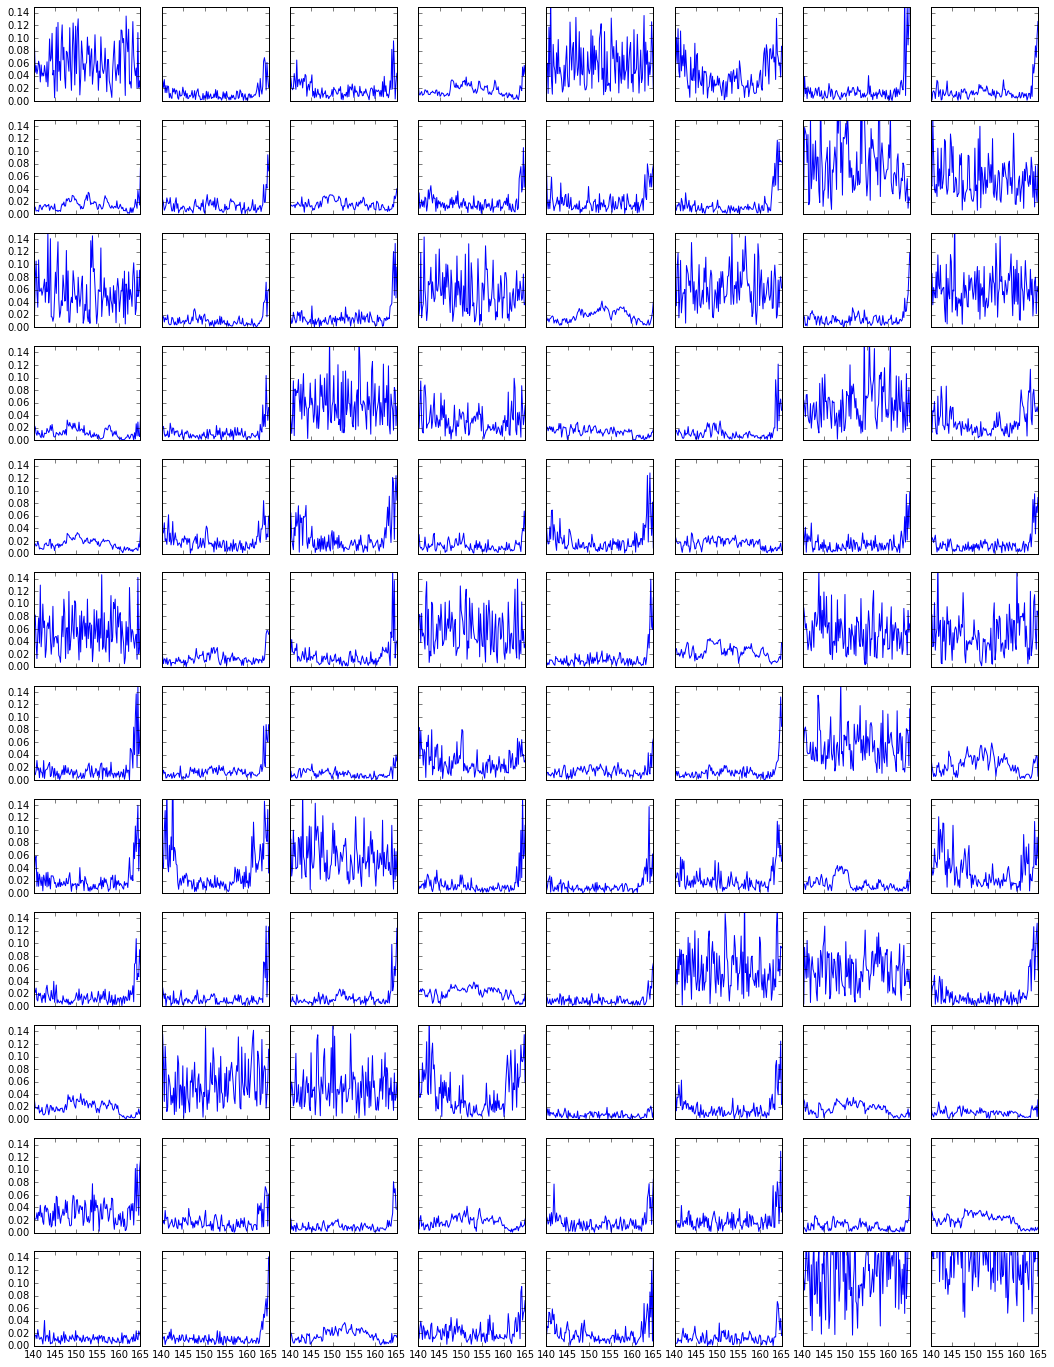

In [65]:
fig,axs = subplots(12,8,figsize=(18,24),sharex=True,sharey=True)
for k,ax in enumerate(axs.flatten()):
    a = ffz[:,k,:]
    ax.plot(freq,np.abs(2*a[8,:]/a[0,:]))
    #ax.axhline(0.5,linestyle='--')
ax.set_ylim(-0,.15)

## 2nd harmonic response (not much at all)

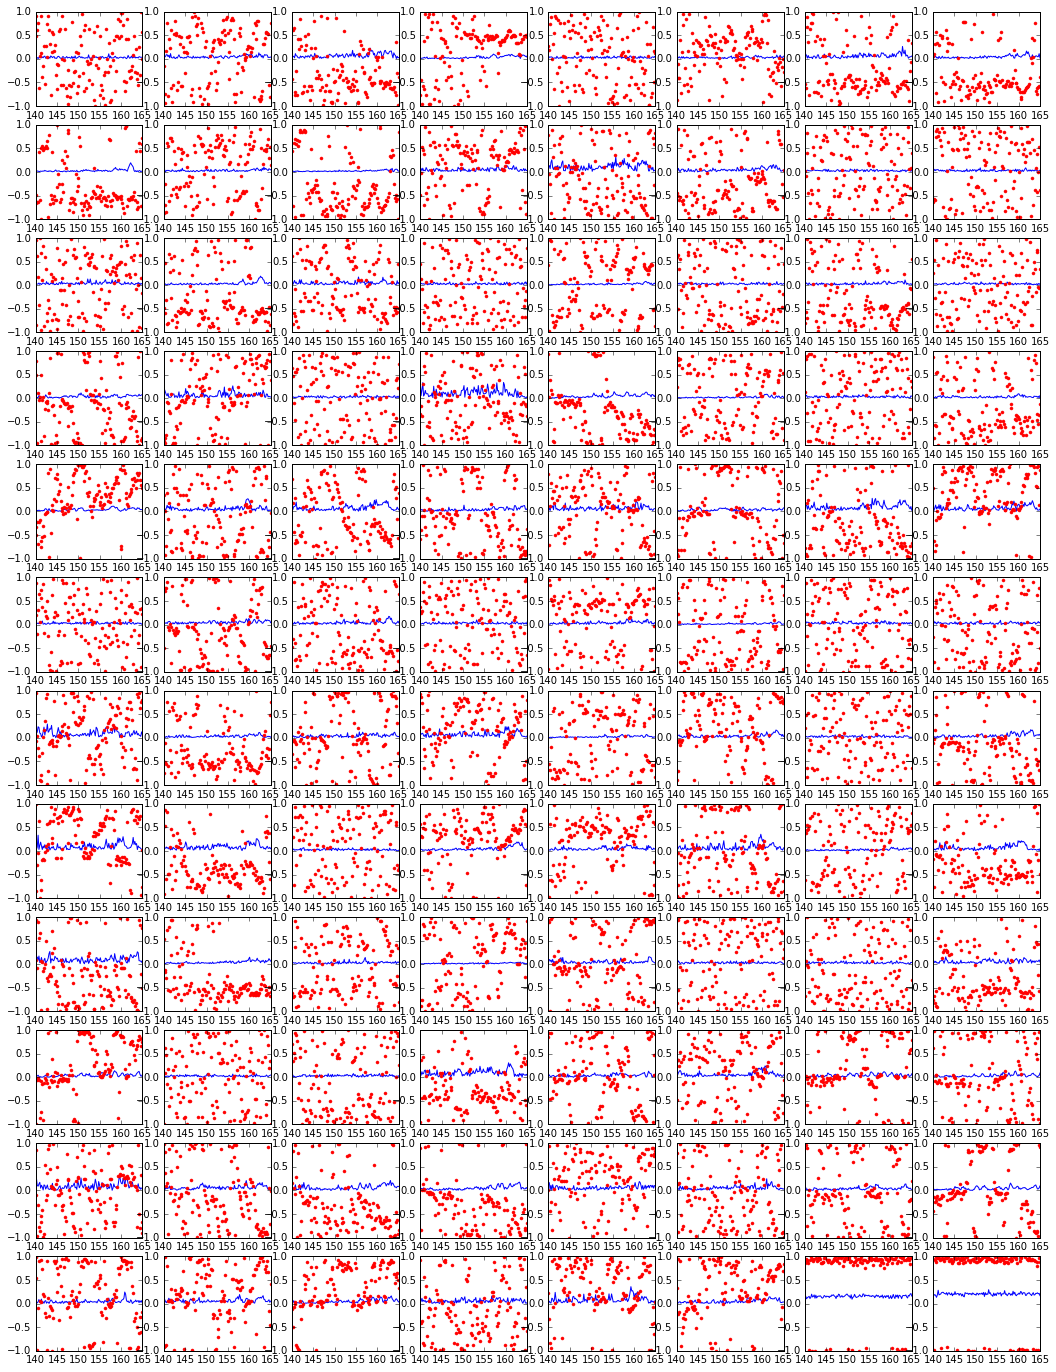

In [55]:
fig,axs = subplots(12,8,figsize=(18,24))
for k,ax in enumerate(axs.flatten()):
    det = df[df.number==k]
    ffr = np.array([row.fractional_frequency_response for _,row in det.iterrows()])
    ffr = ffr/ffr.max(0)[None,:]
    ffz = np.fft.rfft(ffr,axis=0)
    #angle = (det.hwp_motor_steps*3.6).values.astype('float')
    freq = det.mmw_frequency.iloc[0]/1e9
    #ax.imshow(ffr,cmap=cm.RdBu,aspect='auto',interpolation='nearest')
    ax.plot(freq,np.abs(ffz[2,:]/ffz[0,:]))
    ax.plot(freq,np.angle(np.exp(-1j*np.pi/2)*ffz[2,:])/(np.pi),'r.')
    #ax.pcolormesh(freq,angle,ffr,cmap=cm.RdBu)
    #7/0
    ax.set_ylim(-1,1)
    #ax.set_xlim(freq.min(),freq.max())

## Resonator sweeps and chopped data example

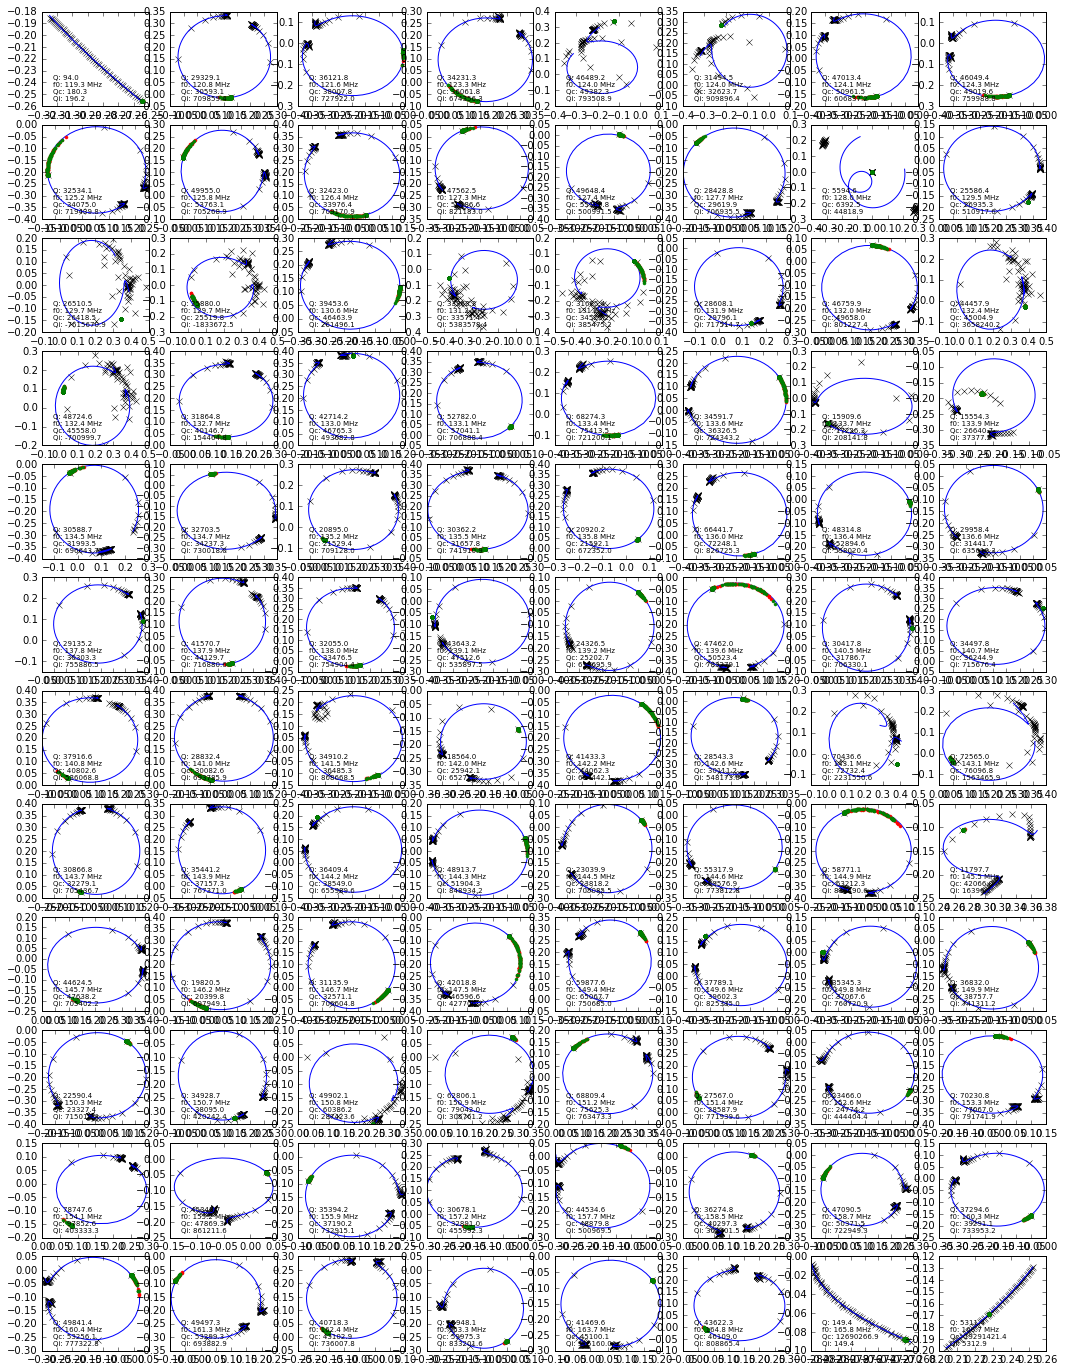

In [60]:
fig,axs = subplots(12,8,figsize=(18,24))
for k,ax in enumerate(axs.flatten()):
    det = df[df.number==k]
    row = det.iloc[0]
    try:
        plot_ri(row.res_s21_data,'kx',ax=ax)
        plot_ri(row.res_model_s21,ax=ax)
        plot_ri(row.folded_s21_raw[:,16],'r.',ax=ax)
        plot_ri(row.folded_s21_raw[:,64+16],'g.',ax=ax)
        
        ax.text(0.1,0.05,("Q: %.1f\nf0: %.1f MHz\nQc: %.1f\nQi: %.1f" %(row.res_Q,row.res_f_0/1e6,1/np.real(1/row.res_Q_e)[()],
                         row.res_Q_i)),
               transform=ax.transAxes,size='x-small',va='bottom')
    except ValueError:
        pass